# Random Forests 6

---

__This Notebook__

- Evaluates the results of the previous notebook's final grid search
- Pick final model by tuning the decision threshold to reasonably maximize sensitivity

__Results__ 

- Upping the number of components in SVD is the single-most helpful factor in achieving results
- The final model requires an 800-component SVD; it's very well possible SVD wasn't necessary after all
- The final params are: ```{'max_depth': 8, 'max_features': 150, 'min_samples_split': 3, 'n_estimators': 100}```
- The best decision threshold = 0.3
- Accuracy, specificity, and most importantly sensitivity balance out at $\approx{99.2\%}$ with little variation
- Mean validation sensitivity was 0.9742 with a mean fit time of $\approx{45 sec}$ 

---

## Setup & Load Results

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp

import custom.new_gridsearch as ng

from datetime import datetime

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-19


In [2]:
# load grid searches
mod_path = os.path.join("data", "3_modeling")
filename = '01192021_rf_gridsearches.joblib'
                
gridsearch_clf = joblib.load(os.path.join(mod_path, filename))

In [3]:
# extract and transform dfs
def transform_dfs(gridsearches):

    def extract_df(dic):
        gd_X = dic['representation']
        gd_res = dic['gridsearch_res'].cv_results_
        df = pd.concat([
                        pd.DataFrame({'representation':[gd_X] * len(gd_res["params"])}),
                        pd.DataFrame(gd_res["params"]),
                        pd.DataFrame(gd_res["mean_test_acc"], columns=["mean_val_acc"]),
                        pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                        pd.DataFrame(gd_res["mean_test_tnr"], columns=["mean_val_tnr"]),
                        pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"])
                       ]
                       , axis=1)
        return df
    
    # create list of dfs
    df_list = []
    for ix, dic in enumerate(gridsearches):
        df_list.append(extract_df(dic))

    # flatten, sort, reindex
    dfm = pd.concat(df_list)
    dfm = dfm.sort_values(by=['mean_val_tpr'], ascending=False)
    dfm.index = range(len(dfm))

    # sort by top mean validation sensitivity
    return dfm

In [4]:
dfm = transform_dfs(gridsearch_clf)

In [5]:
from sklearn.preprocessing import minmax_scale

dfm['mean_fit_time_scaled'] = minmax_scale(dfm['mean_fit_time'], feature_range=(0.92, .99), axis=0, copy=True)

In [6]:
import matplotlib.pyplot as plt

def plot_topscores(X, xlab=True):
    if xlab:
        X['xticks'] = X.agg(lambda x: \
            f"{x['representation']}-{x['max_features']}-{x['n_estimators']}"
            , axis=1)
    plt.figure(figsize=(16, 8))
    plt.plot(np.array(X['mean_val_acc']), label="mean validation accuracy")
    plt.plot(np.array(X['mean_val_tpr']), label="mean validation sensitivity", color='red')
    plt.plot(np.array(X['mean_val_tnr']), label="mean validation specificiy")
    plt.plot(np.array(X['mean_fit_time_scaled']), label="mean fit time, scaled", ls='--', lw=1, color='black')
    plt.title('Evaluating Representations - Sorted By Mean Validation Sensitivity', fontsize=14)
    plt.legend(loc="lower left", fontsize=12)
    plt.axis([0, len(X), 0.9, 1.01])
    if xlab:
        plt.xticks(np.arange(len(X)), tuple(X['xticks']))
        plt.xticks(rotation=90)
    plt.show()

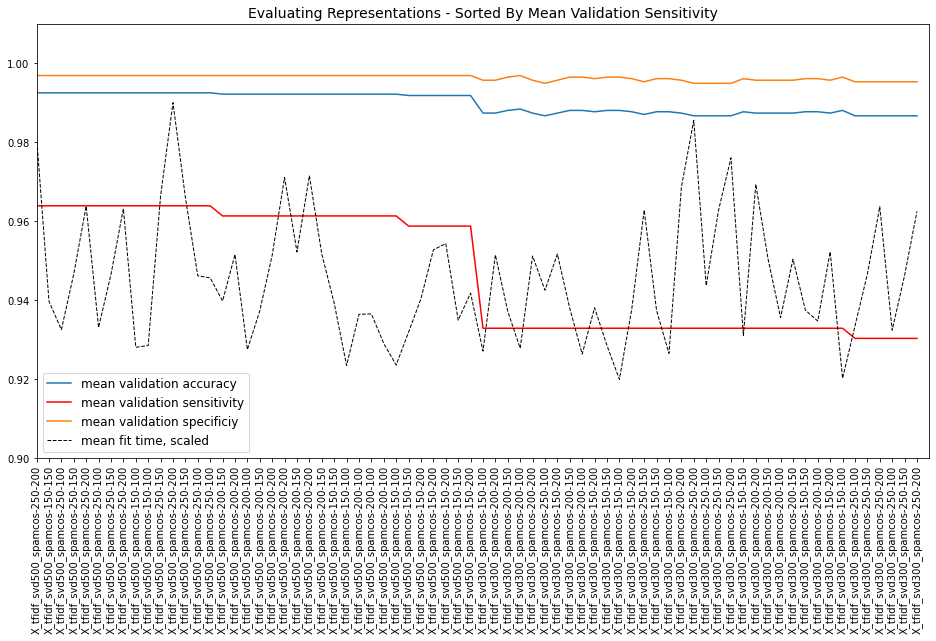

In [7]:
plot_topscores(dfm)

In [8]:
dfm.iloc[:10,:9]

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time
0,X_tfidf_svd500_spamcos,8,250,5,200,0.992483,0.9639,0.996847,81.768335
1,X_tfidf_svd500_spamcos,8,150,5,150,0.992483,0.9639,0.996847,38.167616
2,X_tfidf_svd500_spamcos,5,250,3,100,0.992483,0.9639,0.996847,30.677184
3,X_tfidf_svd500_spamcos,5,250,3,150,0.992483,0.9639,0.996847,45.423729
4,X_tfidf_svd500_spamcos,5,250,3,200,0.992483,0.9639,0.996847,63.327345
5,X_tfidf_svd500_spamcos,5,250,5,100,0.992483,0.9639,0.996847,31.266109
6,X_tfidf_svd500_spamcos,5,250,5,150,0.992483,0.9639,0.996847,45.295634
7,X_tfidf_svd500_spamcos,5,250,5,200,0.992483,0.9639,0.996847,62.658752
8,X_tfidf_svd500_spamcos,8,150,3,100,0.992483,0.9639,0.996847,26.018848
9,X_tfidf_svd500_spamcos,8,150,5,100,0.992483,0.9639,0.996847,26.495482


We probably can just go with the 9th model (penultimate above), since it is the fastest with the same stats. 

It might behoove us to look at variance though, just this once.


In [9]:
# extract and transform dfs
def transform_dfs(gridsearches):

    def extract_df(dic):
        gd_X = dic['representation']
        gd_res = dic['gridsearch_res'].cv_results_
        df = pd.concat([
                        pd.DataFrame({'representation':[gd_X] * len(gd_res["params"])}),
                        pd.DataFrame(gd_res["params"]),
                        pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                        pd.DataFrame(gd_res["std_test_acc"], columns=["std_val_acc"]),
                        pd.DataFrame(gd_res["std_test_tpr"], columns=["std_val_tpr"]),
                        pd.DataFrame(gd_res["std_test_tnr"], columns=["std_val_tnr"]),
                        pd.DataFrame(gd_res["std_fit_time"], columns=["std_fit_time"])
                       ]
                       , axis=1)
        return df
    
    # create list of dfs
    df_list = []
    for ix, dic in enumerate(gridsearches):
        df_list.append(extract_df(dic))

    # flatten, sort, reindex
    dfm = pd.concat(df_list)
    dfm = dfm.sort_values(by=['mean_val_tpr'], ascending=False)
    dfm.index = range(len(dfm))

    # sort by top mean validation sensitivity
    return dfm

In [10]:
dfm = transform_dfs(gridsearch_clf)
dfm.head(10)

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_tpr,std_val_acc,std_val_tpr,std_val_tnr,std_fit_time
0,X_tfidf_svd500_spamcos,8,250,5,200,0.9639,0.005014,0.023563,0.003433,15.524472
1,X_tfidf_svd500_spamcos,8,150,5,150,0.9639,0.005014,0.023563,0.003433,2.144748
2,X_tfidf_svd500_spamcos,5,250,3,100,0.9639,0.005014,0.023563,0.003433,2.471825
3,X_tfidf_svd500_spamcos,5,250,3,150,0.9639,0.005014,0.023563,0.003433,1.511445
4,X_tfidf_svd500_spamcos,5,250,3,200,0.9639,0.005014,0.023563,0.003433,3.777732
5,X_tfidf_svd500_spamcos,5,250,5,100,0.9639,0.005014,0.023563,0.003433,3.469262
6,X_tfidf_svd500_spamcos,5,250,5,150,0.9639,0.005014,0.023563,0.003433,1.360119
7,X_tfidf_svd500_spamcos,5,250,5,200,0.9639,0.005014,0.023563,0.003433,4.593877
8,X_tfidf_svd500_spamcos,8,150,3,100,0.9639,0.005014,0.023563,0.003433,3.119344
9,X_tfidf_svd500_spamcos,8,150,5,100,0.9639,0.005014,0.023563,0.003433,2.830342


It looks like the 10th model has lower variance and not enough of a difference from the 3rd model so I'll just pick the 10th.

## Picking a Decision Threshold


In [11]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

y = y_train.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

In [12]:
import custom.clean_preprocess as cp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))])

X_tfidf = pipe.fit_transform(X_train)

- just too curious, is 800 better than 500 components?

In [13]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

def perform_SVD(X, n_components=300): 
    
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, # term-document matrix
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # return V 
    V = VT.T
    return V # no need to scale for random forests

X_tfidf_svd = perform_SVD(X_tfidf, n_components=800) # oh no I changed it, again...

In [14]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

X_tfidf_svd_allcos = cosine_similarity(X_tfidf_svd)

train_df = pd.DataFrame({'sms':X_train, 'target':y_train})

# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

# calculate average spam similarity on SVD
mean_spam_sims = []

for ix in range(X_tfidf_svd_allcos.shape[0]):
    mean_spam_sims.append(np.mean(X_tfidf_svd_allcos[ix, spam_ix]))

X_tfidf_svd_spamcos = sp.hstack((csr_matrix(mean_spam_sims).T, X_tfidf_svd)) 

In [15]:
# sanity check
X_tfidf_svd_spamcos

<3900x801 sparse matrix of type '<class 'numpy.float64'>'
	with 3123099 stored elements in COOrdinate format>

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier

def print_eval_metrics(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    print(f'accuracy: {acc:0.4f}')
    print(f'sensitivity: {tpr:0.4f}')
    print(f'specificity: {tnr:0.4f}')
    
X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd_spamcos,
                                                  y, 
                                                  stratify=y,
                                                  random_state=42)
  
# setup scorers
scorers = {
    'acc': make_scorer(accuracy_score),
    'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
    'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
}

# instantiate estimator
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# instantiate stratified cv folds
cv_folds = StratifiedKFold(n_splits=10)

- okay I couldn't help myself to one final little grid

In [17]:
# the final final params? oh no...
final_params = {
    'n_estimators' : [100, 150],
    'max_features': [150, 200],  
    'max_depth': [5, 8],                 
    'min_samples_split': [3, 5]
}

grid_search_clf = GridSearchCV(clf, 
                               final_params,
                               scoring=scorers,
                               refit='tpr', 
                               cv=cv_folds, 
                               return_train_score=True, 
                               n_jobs=-1,
                               verbose=1)

In [18]:
# train final model
start_gs = time.time()
grid_search_clf.fit(X_train, y_train)
elapsed_secs = time.time() - start_gs
print(f'Elapsed: {elapsed_secs:0.0f} s')

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 22.0min finished


Elapsed: 1326 s


In [19]:
print(f'Best params: {grid_search_clf.best_params_}')

Best params: {'max_depth': 8, 'max_features': 150, 'min_samples_split': 3, 'n_estimators': 100}


Best params are still the same.

In [20]:
# predict
y_pred = grid_search_clf.predict(X_val)

# confusion matrix on validation set
print(f'Confusion matrix on validation set:')
print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                   columns=['pred_neg', 'pred_pos'],
                   index=['neg', 'pos']))

Confusion matrix on validation set:
     pred_neg  pred_pos
neg       843         3
pos         4       125


In [21]:
# eval metrics
print('Evaluation metrics:')
print_eval_metrics(y_val, y_pred)

Evaluation metrics:
accuracy: 0.9928
sensitivity: 0.9690
specificity: 0.9965


The 800-component SVD is definitely better. I'm starting to question the usefulness of SVD in prediction.

In [22]:
# generate possible scores
y_scores = grid_search_clf.predict_proba(X_val)[:, 1] 

In [23]:
from sklearn.metrics import precision_recall_curve

# generate precision-recall curve
p, r, thresholds = precision_recall_curve(y_val, y_scores)

In [24]:
# mostly unaltered functions from Mr. Arvai
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix
    y_pred_adj = adjusted_classes(y_scores, t)
    
    # print confusion matrix
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_val, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    
    # print eval metrics
    print('\nEvaluation metrics:')
    print_eval_metrics(y_val, y_pred_adj)
    
    # plot the curve
    plt.figure(figsize=(5, 5))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='r', alpha=0.8, where='post')
    plt.fill_between(r, p, step='post', alpha=0.1, color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k', markersize=12)

Confusion Matrix:
     pred_neg  pred_pos
neg       843         3
pos         4       125

Evaluation metrics:
accuracy: 0.9928
sensitivity: 0.9690
specificity: 0.9965


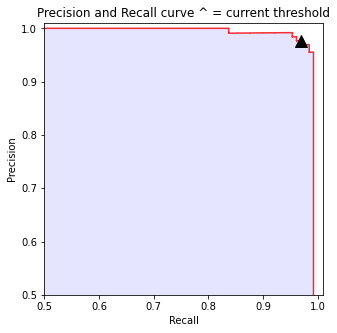

In [25]:
precision_recall_threshold(p, r, thresholds, 0.50)

Confusion Matrix:
     pred_neg  pred_pos
neg       842         4
pos         3       126

Evaluation metrics:
accuracy: 0.9928
sensitivity: 0.9767
specificity: 0.9953


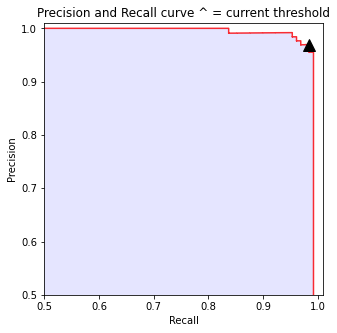

In [26]:
precision_recall_threshold(p, r, thresholds, 0.40)

Confusion Matrix:
     pred_neg  pred_pos
neg       840         6
pos         1       128

Evaluation metrics:
accuracy: 0.9928
sensitivity: 0.9922
specificity: 0.9929


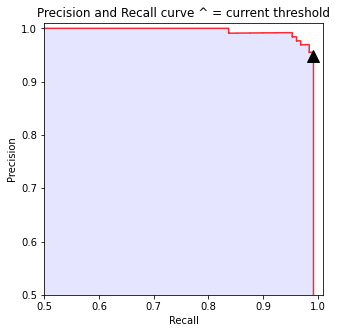

In [27]:
precision_recall_threshold(p, r, thresholds, 0.30)

That's it, 0.3 is probably the best decision threshold since we now have a balance of $\approx{99.2\%}$ sensitivity, specificity, and thus accuracy.

Confusion Matrix:
     pred_neg  pred_pos
neg       839         7
pos         1       128

Evaluation metrics:
accuracy: 0.9918
sensitivity: 0.9922
specificity: 0.9917


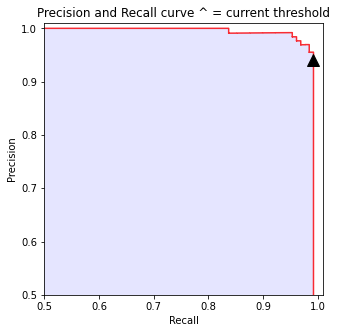

In [28]:
precision_recall_threshold(p, r, thresholds, 0.20)

Just confirming this only decreases specificity.

In [30]:
# persist final search
save_path = os.path.join(mod_path, "".join(["01192021", "_rf_final_search.joblib"]))
joblib.dump(grid_search_clf, save_path)

['data\\3_modeling\\01192021_rf_final_search.joblib']

__Variance and fit times__

In [37]:
def extract_df(dic):
    gd_res = dic.cv_results_
    df = pd.concat([
                    pd.DataFrame(gd_res["params"]),
                    pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                    pd.DataFrame(gd_res["std_test_acc"], columns=["std_val_acc"]),
                    pd.DataFrame(gd_res["std_test_tpr"], columns=["std_val_tpr"]),
                    pd.DataFrame(gd_res["std_test_tnr"], columns=["std_val_tnr"]),
                    pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"]),      
                    pd.DataFrame(gd_res["std_fit_time"], columns=["std_fit_time"])
                   ]
                   , axis=1)
    return df

df = extract_df(grid_search_clf)

In [38]:
df

,max_depth,max_features,min_samples_split,n_estimators,mean_val_tpr,std_val_acc,std_val_tpr,std_val_tnr,mean_fit_time,std_fit_time
0,5,150,3,100,0.966532,0.004453,0.025866,0.003610,38.143411,1.519967
1,5,150,3,150,0.969096,0.004069,0.025236,0.003631,52.165148,2.614126
2,5,150,5,100,0.966532,0.004453,0.025866,0.004016,38.350128,3.632864
3,5,150,5,150,0.969096,0.004545,0.025236,0.004016,52.281698,2.270928
4,5,200,3,100,0.969096,0.004545,0.025236,0.004016,45.503788,2.308378
5,5,200,3,150,0.969096,0.004545,0.025236,0.004016,65.413163,2.673442
6,5,200,5,100,0.969096,0.004545,0.025236,0.004016,42.570340,2.988311
7,5,200,5,150,0.969096,0.004545,0.025236,0.004016,66.311412,2.406102
8,8,150,3,100,0.974224,0.004646,0.023088,0.004016,45.984290,2.080415
9,8,150,3,150,0.971660,0.004347,0.021449,0.004016,66.299655,3.065464


---